# Bibliotecas

In [64]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("/home/lucas/Image-Denoising/src")


import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

import yaml
import json
import locale
from yaml.loader import SafeLoader

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import v2

from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch import Trainer

from noises import AddNoise
from modules.train_module import TrainModule
from models.tokenization import UnPatchTokenizationEinops
from dataset import CustomImageDataset

from transformation import *
from models import *
from losses import *

# 1. Dataframe dos resultados

In [66]:
path = "/home/lucas/experimentos/Transformer_Torch_V2_Normal/version_14/metrics.csv"

df = pd.read_csv(path)
df

,loss,epoch,step,val_loss
0,2.927010e+06,0,49,NaN
1,1.790926e+06,0,99,NaN
2,1.276614e+06,0,149,NaN
3,9.496676e+05,0,199,NaN
4,7.699632e+05,0,249,NaN
...,...,...,...,...
2541,3.794091e+03,206,116799,NaN
2542,4.100615e+03,206,116849,NaN
2543,4.575139e+03,206,116899,NaN
2544,5.746694e+03,206,116949,NaN


# 2. Obtendo a loss de treino e de validacao

## 2.1 Validacao

In [67]:
#df_val_loss = df[df['val_loss'].apply(lambda x: pd.notna(x))].copy()
df_val_loss = df[["epoch","val_loss"]].copy()
df_val_loss.rename({"val_loss":"loss"},inplace=True,axis=1)
df_val_loss["Split"] = "Validação"

df_val_loss = df_val_loss[df_val_loss.loss.apply(lambda x: pd.notna(x))]
df_val_loss

,epoch,loss,Split
11,0,189783.781250,Validação
23,1,94666.367188,Validação
35,2,62857.109375,Validação
48,3,48818.996094,Validação
60,4,44858.480469,Validação
...,...,...,...
2495,202,5002.502441,Validação
2508,203,4924.807617,Validação
2520,204,4888.220703,Validação
2532,205,4699.842773,Validação


## 2.2 Treino

In [68]:
#index_val = df_val_loss.index.tolist()

#index_val = [x - 1 for x in index_val]
#df_train_loss = df.loc[index_val].copy()
df_train_loss = df[["epoch","loss"]].copy()

df_train_loss["Split"] = "Treino"
df_train_loss

,epoch,loss,Split
0,0,2.927010e+06,Treino
1,0,1.790926e+06,Treino
2,0,1.276614e+06,Treino
3,0,9.496676e+05,Treino
4,0,7.699632e+05,Treino
...,...,...,...
2541,206,3.794091e+03,Treino
2542,206,4.100615e+03,Treino
2543,206,4.575139e+03,Treino
2544,206,5.746694e+03,Treino


# 3. Grafico comparativo de Loss

In [69]:
df_concat = pd.concat([df_train_loss,df_val_loss])

In [70]:
df_concat["loss"] = np.log(df_concat["loss"])

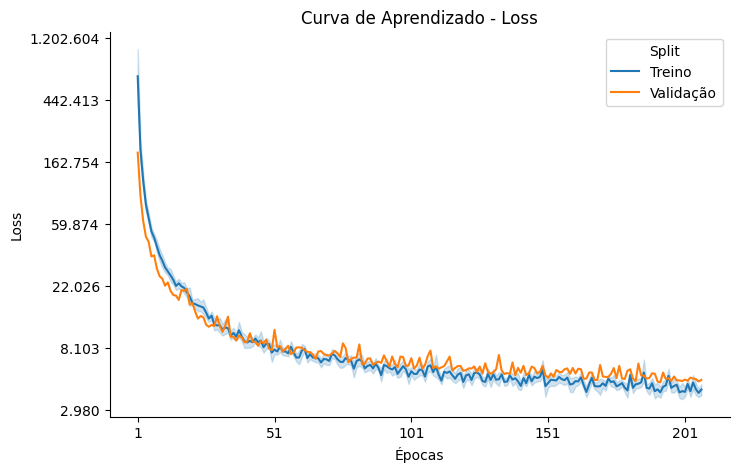

In [71]:
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(data=df_concat,x="epoch",y="loss",hue="Split",ax=ax)
ax.set_yticklabels([
        locale.format_string("%d", np.e**(int(x.get_text())), grouping=True) for x in ax.get_yticklabels()
    ])

ax.set_xticklabels([
        locale.format_string("%d", int(x.get_text().replace('−', '-'))+1, grouping=True) for x in ax.get_xticklabels()
    ])

ax.set_ylabel("Loss")
ax.set_xlabel("Épocas")

ax.set_title("Curva de Aprendizado - Loss")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.show()

# 4. Carregando modelo para validação

## 4.1 Parâmetros

In [72]:
with open("/home/lucas/experimentos/Transformer_Torch_V2_Normal/version_14/hparams.yml","r") as infile:
    params = yaml.load(infile,Loader=SafeLoader)
    infile.close()

batch_size = params["dataset"]["batch_size"]                                        
num_workers = params["dataset"]["num_workers"]                                      
epochs = params["train"]["epochs"]                                                  
patience = params["train"]["patience"]                                              
name_exp = params["name_exp"]                                                       
dir_save_logs = params["train"]["dir_save_logs"]                                    
name_to_save = params["train"]["name_to_save"]                                      
top_k = params["train"]["top_k"]                                                    
                                                                                    
noise = eval(params["train"]["noise"]["model"])                                     
                                                                                    
transform = eval(params["dataset"]["transformation"])                               
                                                                                    
path = params["dataset"]["dataframe"]

In [73]:
print(json.dumps(params,indent=3))

{
   "dataset": {
      "batch_size": 32,
      "dataframe": "/home/lucas/Image-Denoising/dataframes/dataframe_v3.csv",
      "num_workers": 8,
      "transformation": "get_transform_v3()"
   },
   "name_exp": "Transformer_Torch_V2_Normal",
   "train": {
      "dir_save_logs": "/home/lucas/experimentos/",
      "epochs": 512,
      "loss": {
         "model": "MSELossPatchEinops(patch_size=14)"
      },
      "model": "VisionModelTransformerTorchV2(img_size=(batch_size,3,224,224), patch_size=14, token_len=512, embed_dim=512, num_heads=8, num_layers=6)",
      "name_to_save": "checkpoint-{epoch:02d}-{val_loss:.2f}",
      "noise": {
         "model": "AddNoise(ksize=(23,23))"
      },
      "optim": {
         "model": "torch.optim.Adam(model.parameters(),lr=0.0001)"
      },
      "patience": 15,
      "top_k": 1,
      "train_module": "TrainModule(model,loss_fn,optimizer)"
   }
}


## 4.2 Carregando dataframe e dataloader

In [74]:
df = pd.read_csv(path)

val = df[df["split"] == 'val']

val_dataset = CustomImageDataset(val,transform,noise)

custom_dataloader_val = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False)

## 4.3 Carregando modelo

In [76]:
model = eval(params["train"]["model"])                                              
model = model.cpu()                                                                
                                                                                    
loss_fn = eval(params["train"]["loss"]["model"])                                    
optimizer = eval(params["train"]["optim"]["model"])                                 
                                                                                    
model = TrainModule.load_from_checkpoint(
    "/home/lucas/experimentos/Transformer_Torch_V2_Normal/version_14/checkpoint-epoch=191-val_loss=4636.99.ckpt",
    map_location={"cuda:0":"cpu","cuda:1":"cpu","cuda":"cpu"},
    model=model,
    loss=loss_fn,
    optim=optimizer
)

In [16]:
#class AddNoise(torch.nn.Module):
#    def forward(self, img, noise,**kwargs):
#        noisy_image = add_noise(img, noise_type=noise,**kwargs)
#
#        return Image.fromarray(noisy_image)

batch_size = 16
num_workers = 8
lr = 0.001

noise = AddNoise(ksize=(23,23))
transform = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True)
])

path = "/home/lucas/Image-Denoising/dataframes/dataframe_v3.csv"




model = VisionModel(img_size=(batch_size,3,224,224), patch_size=14, token_len=512, embed_dim=512, num_heads=8, num_layers=6)

model = model.cpu()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

model = TrainModule.load_from_checkpoint(
    "/home/lucas/experimentos/Transformer_Torch_V2_Normal/version_14/checkpoint-epoch=150-val_loss=4987.86.ckpt",
    map_location={"cuda:0":"cpu","cuda:1":"cpu","cuda":"cpu"},
    model=model,
    loss=loss_fn,
    optim=optimizer
)

# 5. Inferencias do modelo

## 5.1 Conjunto de validação

In [77]:
val.noise.unique()

array(['salt_pepper', 'gaussian', 'poisson', 'exponential', 'blur',
       'uniform'], dtype=object)

In [82]:
i = 0
stop = 5
for ori_img, noi_img in custom_dataloader_val:
    if(i == stop):
        break
    i+=1

denoised = model.model(noi_img)
un_patch = UnPatchTokenizationEinops(14,224)
denoised = un_patch(denoised)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.078234926..0.9827448].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.045605376..1.0080988].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.016875431..1.0173817].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013908431..0.947847].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.070974976..0.9643694].


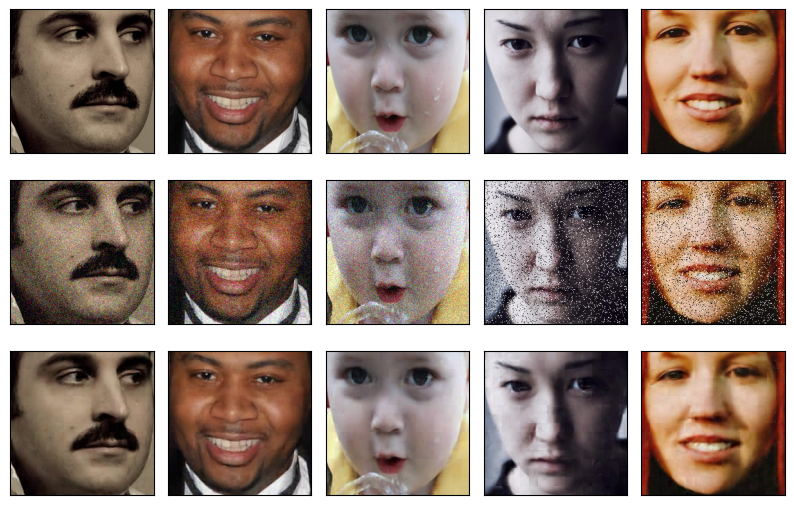

In [83]:
col = 5
row = 3

init = 0

fig, ax = plt.subplots(row,col,figsize=(10,10))

for itr in range(0,col):
    ax[0,itr].imshow(ori_img[itr+init].permute(1,2,0).detach().numpy())
    ax[1,itr].imshow(noi_img[itr+init].permute(1,2,0).detach().numpy())
    ax[2,itr].imshow(denoised[itr+init].permute(1,2,0).detach().numpy())
    
    for itr_ in range(row):
        ax[itr_,itr].yaxis.set_visible(False)
        ax[itr_,itr].xaxis.set_visible(False)

plt.subplots_adjust(wspace=0.1, hspace=-0.6)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.045605376..1.0080988].


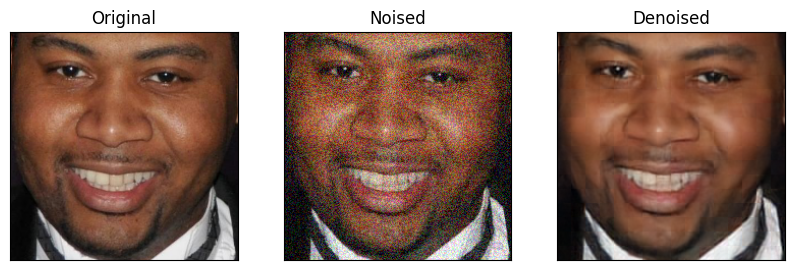

In [85]:
idx_img = 1

fig, ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow(ori_img[init+idx_img].permute(1,2,0).detach().numpy())
ax[1].imshow(noi_img[init+idx_img].permute(1,2,0).detach().numpy())
ax[2].imshow(denoised[init+idx_img].permute(1,2,0).detach().numpy())

ax[0].set_title("Original")
ax[1].set_title("Noised")
ax[2].set_title("Denoised")

for itr in range(3):
    ax[itr].yaxis.set_visible(False)
    ax[itr].xaxis.set_visible(False)
plt.show()